The purpose of this notebook is to present some preliminary results and findings.

In [1]:
# imports
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [16, 8]
cmap = plt.cm.get_cmap('plasma', 3)


import numpy as np
import scipy.stats
import scipy.optimize
import sklearn.decomposition
import sklearn.cluster
import time
import wfdb
from scipy.special import softmax

from collections import Counter
from functools import reduce

# The data

In [2]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/119')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/119', 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)

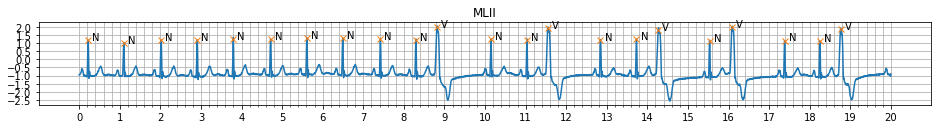

In [3]:
t0 = (2*60 + 30) * record.fs  # 2:30

dt = 20  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = (annotation.sample >= t0) & (annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = symbols[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

The MIT-BIH Arrhythmia Database contains labeled ECG recordings (30 min each) of patients with different conditions.
Above we see a sequence of 10 normal beats (Sinus rhythm with P wave, QRS complex and T wave) followed by a pattern of two normal beats alternating with one premature ventricular contraction (PVC, characterized by the missing P wave and the inverted T wave).

# Preprocessing

In [4]:
cuts = annotation.sample[(symbols == 'N') | (symbols == 'V')]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len),  # resample so we have the same number of samples per curve
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = data - data.mean(axis=1)[:, np.newaxis]  # vertical align

We cut the data at the annotated R waves into pieces. This leaves us with a time series of short curves that shall be modeled as a HMM with functional emissions in the following.

To allow for the use of some standard tools, we need to have the same number of samples per curve. We achieve this via linear interpolation of the shorter curves that have less samples. This is not ideal if we later want to analyze derivatives of the curves (because it introduces local linearity that is not there in the original data) and there are functional data analysis methods that allow to avoid this (basis function representation), but for now this is good enough.

Also there are slow trends that cause the curves to be vertically misaligned. This "baseline drift" is not medically meaningful and we remove it by simply subtracting its mean from every curve. There are better ways to remove baseline drift from ECG data but for now, this must suffice.

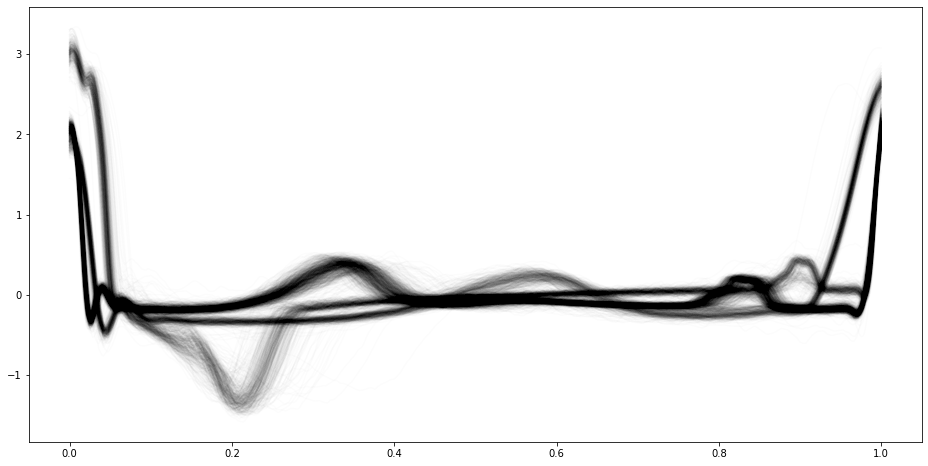

In [5]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, data.transpose(), color='black', alpha=0.01)
pass

Note that the ideal way to cut the data would be to cut between the T wave of one beat and the P wave of the next. However, this would be very hard to automate especially considering that non-standard beats (like the PVC) do not necessarily have a P wave, hence cutting at the R wave is the only viable option to us.

As a consequence, we see not two but three different types of curves after cutting the data: 
1. NN: A curve that goes from the R wave of a normal beat to the R wave of the next normal beat
2. NV: A curve that goes from the R wave of a normal beat to the R wave of a PVC beat, without a P wave
3. VN: A curve that goes from the R wave of a PVC beat to the R wave of a normal beat with inverted T wave

(There are no two consecutive PVC beats in the data.)

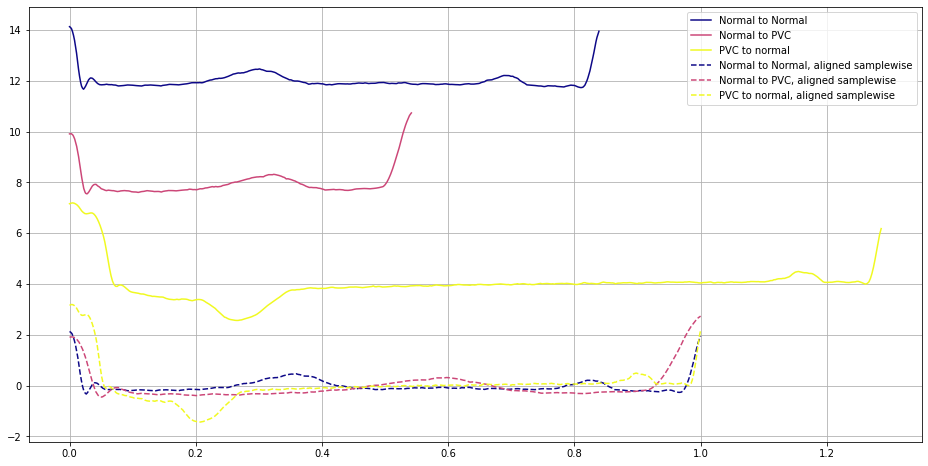

In [6]:
plt.plot(np.linspace(0, periods[37], data.shape[1]), data[37]+12, color=cmap(0), label='Normal to Normal')
plt.plot(np.linspace(0, periods[38], data.shape[1]), data[38]+8, color=cmap(1), label='Normal to PVC')
plt.plot(np.linspace(0, periods[39], data.shape[1]), data[39]+4, color=cmap(2), label='PVC to normal')

plt.plot(np.linspace(0, 1, data.shape[1]), data[37], '--', 
         color=cmap(0), label='Normal to Normal, aligned samplewise')
plt.plot(np.linspace(0, 1, data.shape[1]), data[38], '--', 
         color=cmap(1), label='Normal to PVC, aligned samplewise')
plt.plot(np.linspace(0, 1, data.shape[1]), data[39], '--', 
         color=cmap(2), label='PVC to normal, aligned samplewise')

plt.grid()
plt.legend()
pass

Note that even though the distance between the R wave and the T wave is approximately equal in the three waves, due to the fact that the original total length of the curves is so different, when we plot the curves aligned samplewise after resampling the T waves don't align. Same goes for the distance between the P wave and the next R wave (for the curves that have P waves).

# PCA

Now that we have the same amount of samples per curve we can do a principal component analysis for dimensionality reduction. This will be useful for different reasons:
1. It allows us to visualize the data more neatly.
2. It is absolutely necessary to fit more complicated models that require numerical optimization later on (namely HMMs).
3. Often, the first components actually have an intuitive meaning, controlling some global property of the shape of the curves, witch makes our results easier to interpret.

In [7]:
pca = sklearn.decomposition.PCA()
data_pca = pca.fit_transform(data)

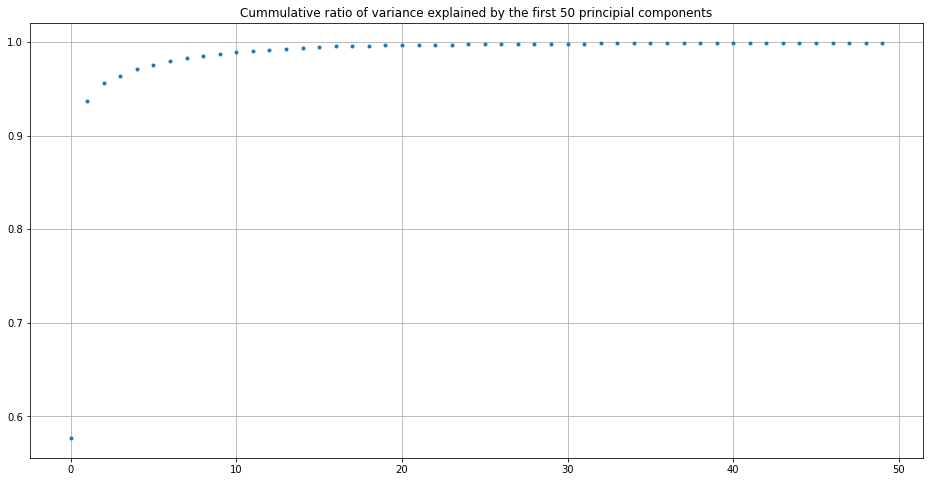

In [8]:
plt.plot(pca.explained_variance_ratio_.cumsum()[:50], '.')
plt.grid()
plt.title('Cummulative ratio of variance explained by the first 50 principial components')
pass

0.9889 percent of the variance in the data is explained by the ten first principal components.

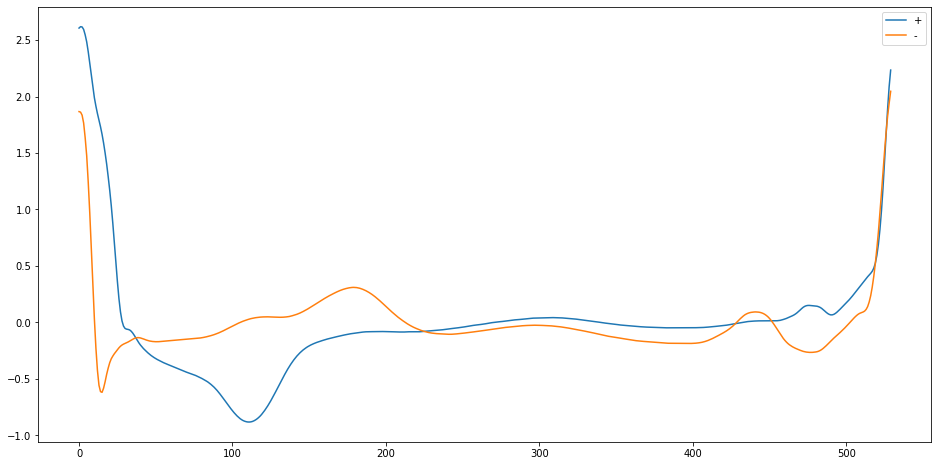

In [9]:
# Results of adding or subtracting the principal component scaled by the standard deviation of it's scores
#  from the mean curve
component = 0
plt.plot(pca.mean_ + data_pca[:,component].std() * pca.components_[component], label='+')
plt.plot(pca.mean_ - data_pca[:,component].std() * pca.components_[component], label='-')
plt.legend()
pass

The first principal component inverts the T wave, distinguishing the VN curves from the others

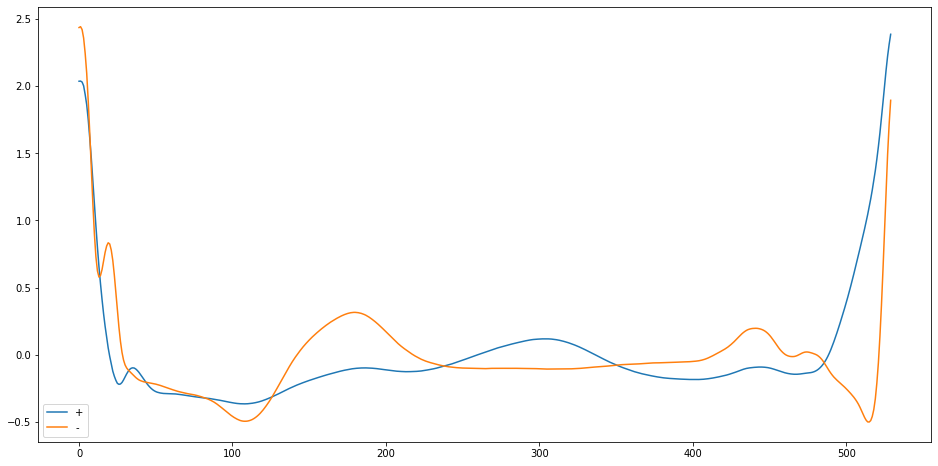

In [10]:
# Results of adding or subtracting the principal component scaled by the standard deviation of it's scores
#  from the mean curve
component = 1
plt.plot(pca.mean_ + data_pca[:,component].std() * pca.components_[component], label='+')
plt.plot(pca.mean_ - data_pca[:,component].std() * pca.components_[component], label='-')
plt.legend()
pass

The second principal component shifts the T wave back and removes the P wave, distinguishing NV waves from NN waves.

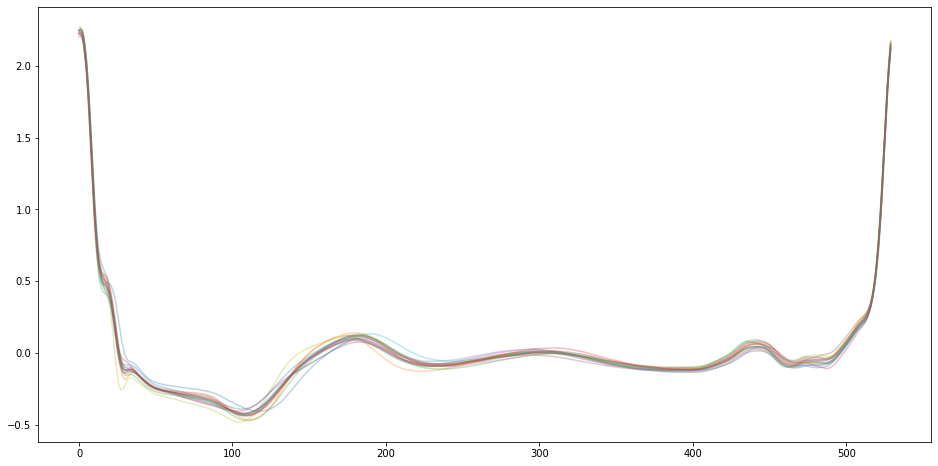

In [11]:
# Results of adding or subtracting later principal components scaled by the standard deviation of their scores
#  from the mean curve
components = range(2,10)
plt.plot(
    pca.mean_[:, np.newaxis] 
    + (pca.components_[components] * data_pca[:,components].std(axis=0)[:, np.newaxis]).transpose(), alpha=0.3
)
plt.plot(
    pca.mean_[:, np.newaxis] 
    - (pca.components_[components] * data_pca[:,components].std(axis=0)[:, np.newaxis]).transpose(), alpha=0.3
)
pass

The third to tenth principal components influence only details of the shape of the curves.

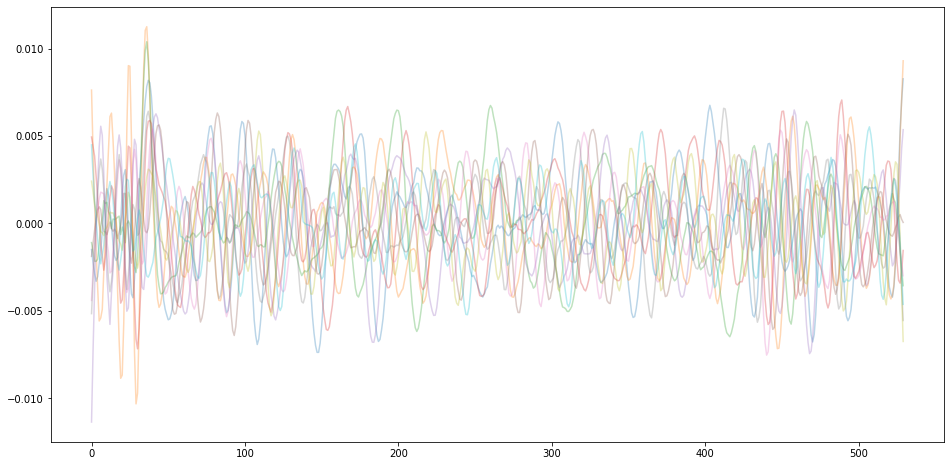

In [12]:
# Later PCs scaled by the standard deviation of their scores
components = range(30,40)
plt.plot((pca.components_[components] * data_pca[:,components].std(axis=0)[:, np.newaxis]).transpose(), alpha=0.3)
pass

Later principal components seem to cover high frequency low amplitude information that is unlikely to be medically meaningful and can be considered noise.

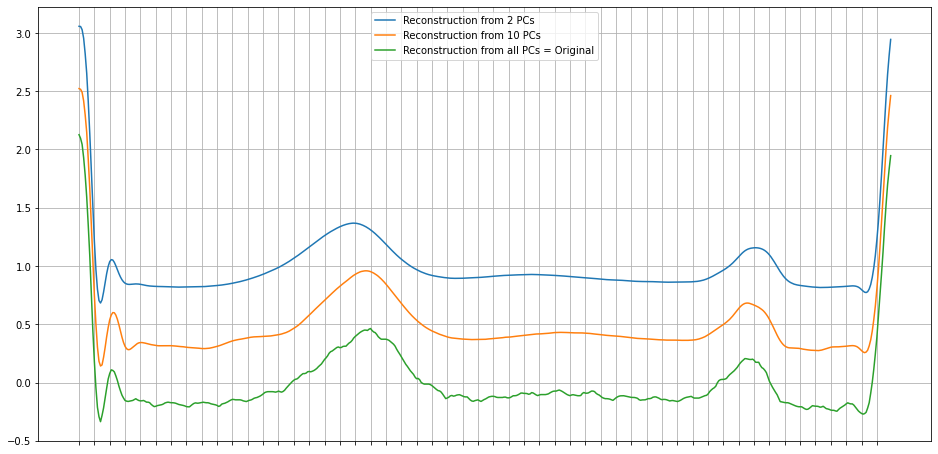

In [13]:
curve = 37
plt.plot(pca.mean_ + np.dot(data_pca[curve,:2], pca.components_[:2]) + 1, label='Reconstruction from 2 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:10], pca.components_[:10]) + 0.5, label='Reconstruction from 10 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:], pca.components_[:]), label='Reconstruction from all PCs = Original')
plt.xticks(np.arange(0, data.shape[1], 10), labels=[])
plt.grid()
plt.legend()
pass

We see this when try to reconstruct the original data from the first principal components: To get the basic shape right the first two components are generally sufficient, to get the exact position of the P and T waves we need the first ten. 

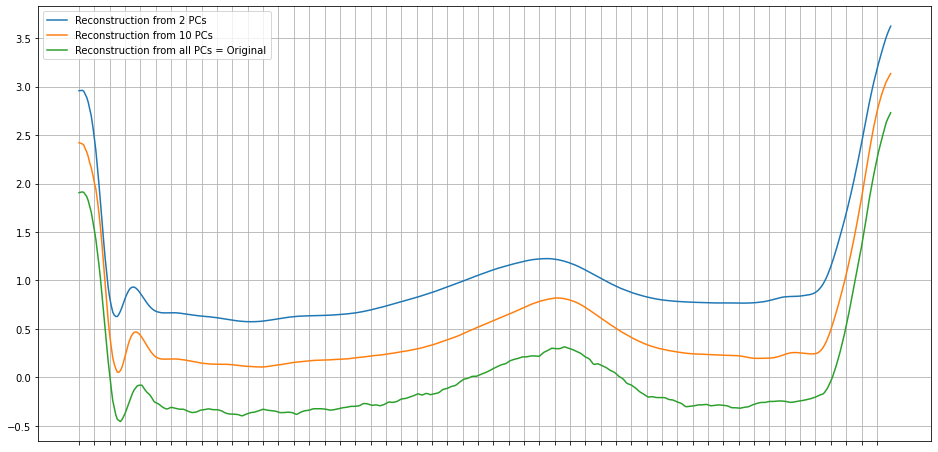

In [14]:
curve = 38
plt.plot(pca.mean_ + np.dot(data_pca[curve,:2], pca.components_[:2]) + 1, label='Reconstruction from 2 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:10], pca.components_[:10]) + 0.5, label='Reconstruction from 10 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:], pca.components_[:]), label='Reconstruction from all PCs = Original')
plt.xticks(np.arange(0, data.shape[1], 10), labels=[])
plt.grid()
plt.legend()
pass

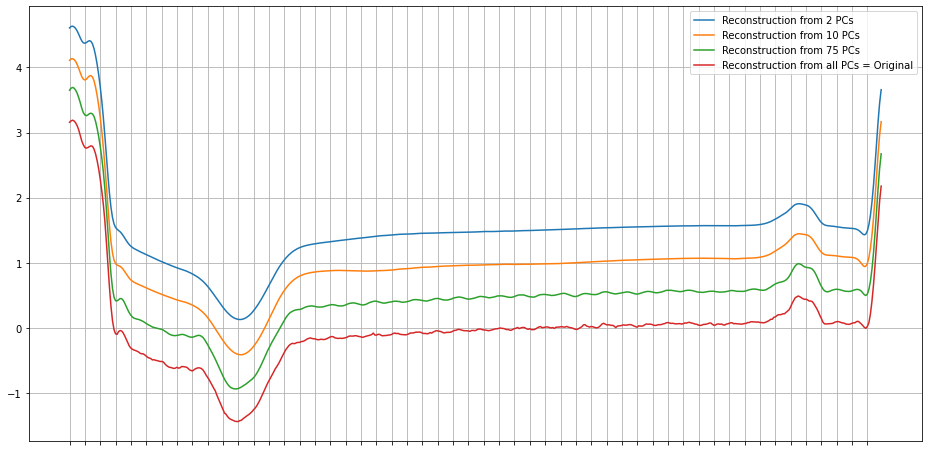

In [15]:
curve = 39
plt.plot(pca.mean_ + np.dot(data_pca[curve,:2], pca.components_[:2]) + 1.5, label='Reconstruction from 2 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:10], pca.components_[:10]) + 1, label='Reconstruction from 10 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:75], pca.components_[:75]) + 0.5, label='Reconstruction from 75 PCs')
plt.plot(pca.mean_ + np.dot(data_pca[curve,:], pca.components_[:]), label='Reconstruction from all PCs = Original')
plt.xticks(np.arange(0, data.shape[1], 10), labels=[])
plt.grid()
plt.legend()
pass

Getting the exact shape of the inverted T wave and the P wave in the V to N curve right requires a much higher number of principal components witch suggest that there is much variation in the data there that is especially hard to capture with linear methods.

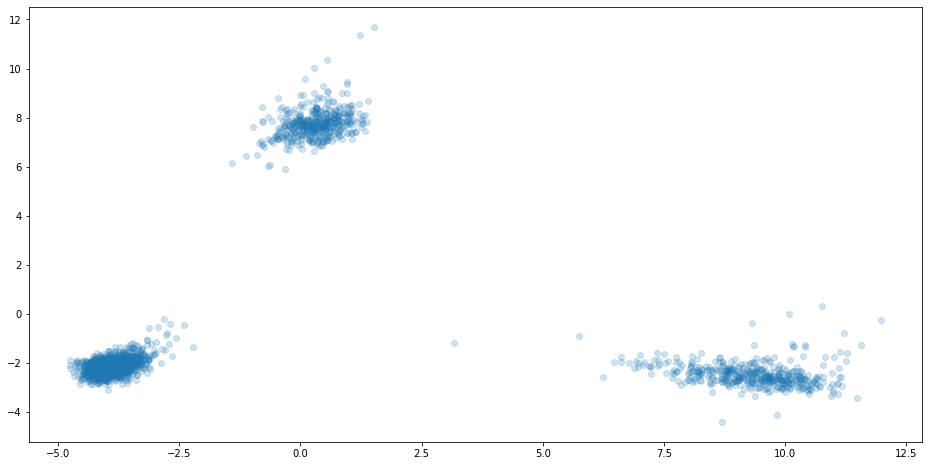

In [16]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.2)
pass

Plotting the principal component scores of the first two PCs reveals three neatly separated clusters...

# k-means

In [17]:
nr_comp = 2
kmeans = sklearn.cluster.KMeans(3).fit(data_pca[:,:nr_comp])

In [18]:
nn, nv, vn = kmeans.labels_[[37, 38, 39]]

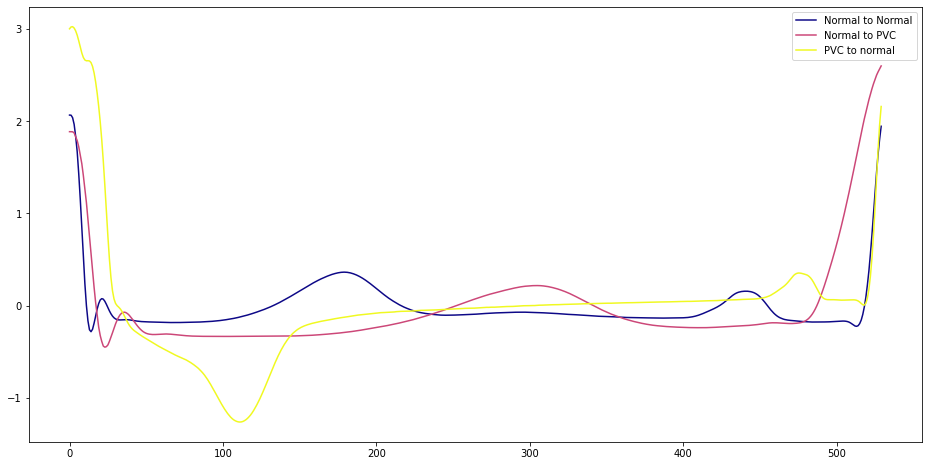

In [19]:
plt.plot(pca.mean_ + np.matmul(kmeans.cluster_centers_, pca.components_[:nr_comp])[nn],
         color=cmap(0), label='Normal to Normal')
plt.plot(pca.mean_ + np.matmul(kmeans.cluster_centers_, pca.components_[:nr_comp])[nv],
         color=cmap(1), label='Normal to PVC')
plt.plot(pca.mean_ + np.matmul(kmeans.cluster_centers_, pca.components_[:nr_comp])[vn],
         color=cmap(2), label='PVC to normal')
plt.legend()
pass

...and finding the means of these via the k-means algorithm indeed shows them to correspond to the three types of curves: NN, NV. and VN.

Here is the plot of all curves from above but now colored according to the clusters found by k-means.

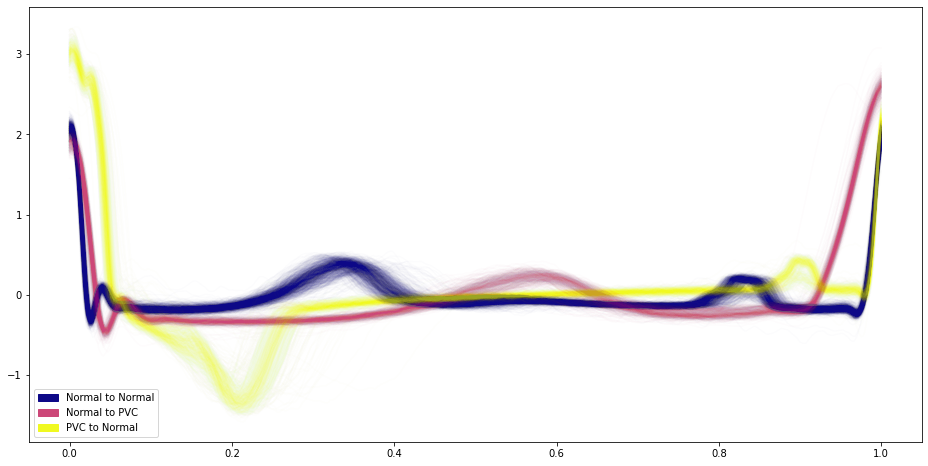

In [20]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, data[kmeans.labels_ == nn].transpose(), color=cmap(0), alpha=0.01)
plt.plot(t, data[kmeans.labels_ == nv].transpose(), color=cmap(1), alpha=0.01)
plt.plot(t, data[kmeans.labels_ == vn].transpose(), color=cmap(2), alpha=0.01)
plt.legend([Patch(color=cmap(c)) for c in (0, 1, 2)], ['Normal to Normal', 'Normal to PVC', 'PVC to Normal'])
pass

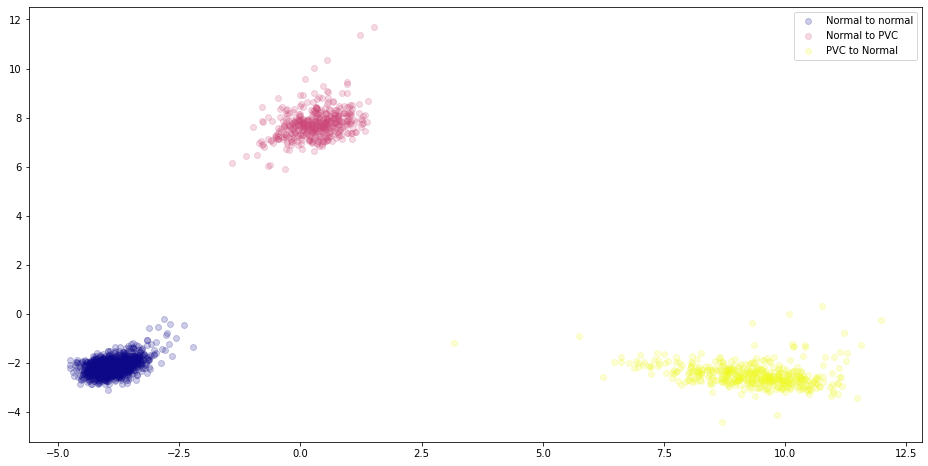

In [21]:
component1, component2 = 0, 1
plt.scatter(data_pca[kmeans.labels_ == nn, component1], data_pca[kmeans.labels_ == nn, component2], alpha=0.2, 
            color=cmap(0), label='Normal to normal')
plt.scatter(data_pca[kmeans.labels_ == nv, component1], data_pca[kmeans.labels_ == nv, component2], alpha=0.2, 
            color=cmap(1), label='Normal to PVC')
plt.scatter(data_pca[kmeans.labels_ == vn, component1], data_pca[kmeans.labels_ == vn, component2], alpha=0.2, 
            color=cmap(2), label='PVC to Normal')
plt.legend()
pass

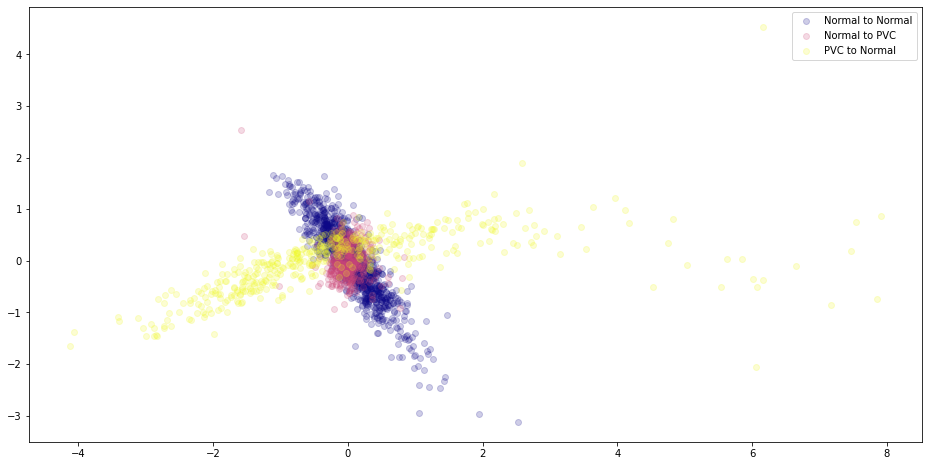

In [22]:
component1, component2 = 2, 3
plt.scatter(data_pca[kmeans.labels_ == nn, component1], data_pca[kmeans.labels_ == nn, component2], alpha=0.2, 
            color=cmap(0), label='Normal to Normal')
plt.scatter(data_pca[kmeans.labels_ == nv, component1], data_pca[kmeans.labels_ == nv, component2], alpha=0.2, 
            color=cmap(1), label='Normal to PVC')
plt.scatter(data_pca[kmeans.labels_ == vn, component1], data_pca[kmeans.labels_ == vn, component2], alpha=0.2, 
            color=cmap(2), label='PVC to Normal')
plt.legend()
pass

We can now see that, while the first two principal components explain variance between the clusters, the later components explain variance within the clusters. For example, we can see above that the third principal component mainly explains variance among the PVC to Normal curves, the fourth component explains variance among Normal to Normal curves. Also, there seems to be a roughly linear dependence between those dimensions the direction of which is inverted between the two types of curves.

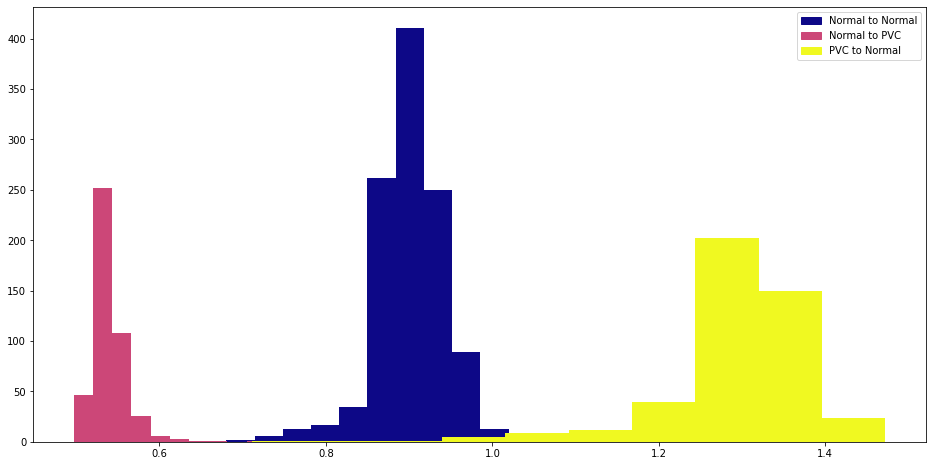

In [23]:
plt.hist(periods[kmeans.labels_ == nn], color=cmap(0))
plt.hist(periods[kmeans.labels_ == nv], color=cmap(1))
plt.hist(periods[kmeans.labels_ == vn], color=cmap(2))
plt.legend([Patch(color=cmap(c)) for c in (0, 1, 2)], ['Normal to Normal', 'Normal to PVC', 'PVC to Normal'])
pass

These types of curves each have their own distinct distribution of lengths.

In [24]:
s = symbols[(symbols == 'N') | (symbols == 'V')]
labels_annotated = np.array([
    nn if s[t] == 'N' and s[t+1] == 'N'
    else nv if s[t] == 'N' and s[t+1] == 'V'
    else vn
    for t in range(data.shape[0])
])

In [25]:
(labels_annotated != kmeans.labels_).sum()

0

Finally, the clusters we found in the data (in a 100% data driven, unsupervised way), align exactly with the annotations by medical experts in the original data.

# Markov chain

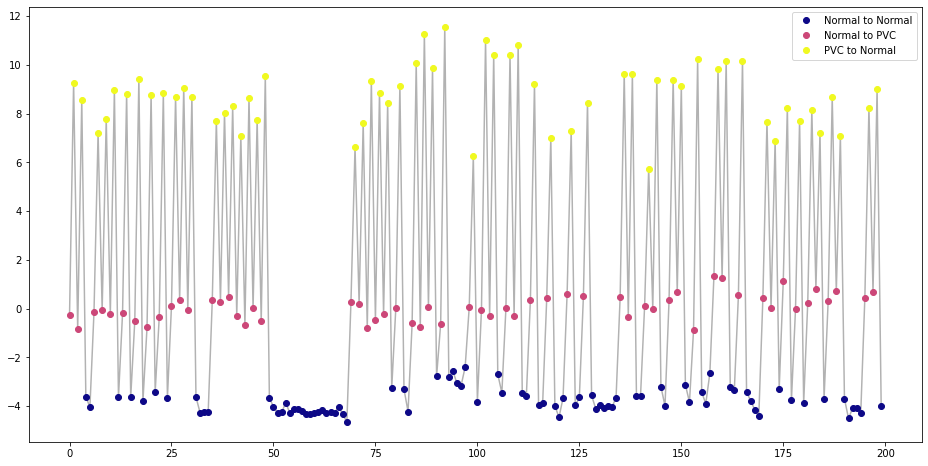

In [26]:
start, stop = 1600, 1800
component = 0

plt.plot(data_pca[:,component][start:stop], color='black', alpha=0.3)
plt.plot(np.where(kmeans.labels_[start:stop] == nn)[0], 
         data_pca[:,component][start:stop][kmeans.labels_[start:stop] == nn], 'o', 
         color=cmap(0), label='Normal to Normal')
plt.plot(np.where(kmeans.labels_[start:stop] == nv)[0], 
         data_pca[:,component][start:stop][kmeans.labels_[start:stop] == nv], 'o', 
         color=cmap(1), label='Normal to PVC')
plt.plot(np.where(kmeans.labels_[start:stop] == vn)[0], 
         data_pca[:,component][start:stop][kmeans.labels_[start:stop] == vn], 'o', 
         color=cmap(2), label='PVC to Normal')

plt.legend()
pass

Until now, we only concerned ourselves with the shape of the individual curves, now lets turn our attention to the sequence of states. The plot above displays the sequence of curves in a 3 min interval of the recording, with the scores of the first principal component on the y axis.

We can see the data has a rich temporal structure: There are intervals with normal Beats only but for most of the time we have patterns of PVC beats alternating with either one, two, or three normal beats (corresponding to curves NV, VN; NV, VN, NN; and NV, VN, NN, NN respectively).

Obviously, the simple Markov property does not hold: Which state follows an NN curve depends on whether the two previous curves were NN, NN; VN, NN; or NV, VN. Maybe we can model the series as a second or third order Markov chain.

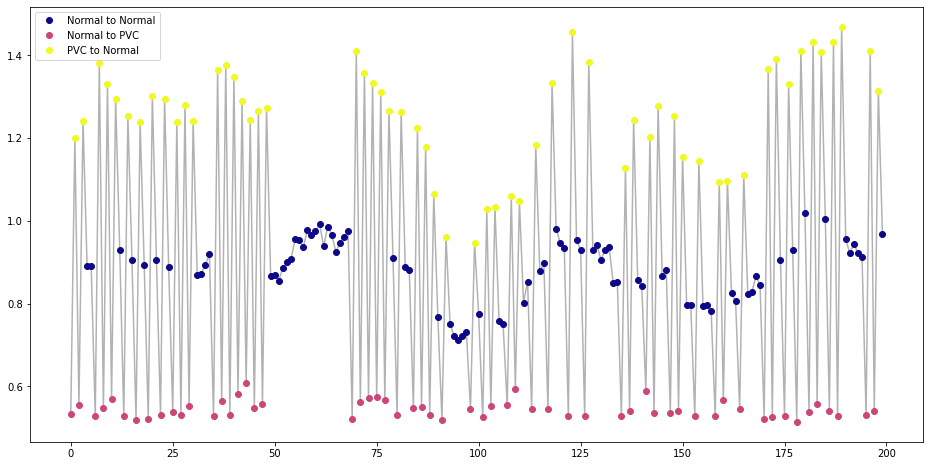

In [27]:
start, stop = 1600, 1800

plt.plot(periods[start:stop], color='black', alpha=0.3)
plt.plot(np.where(kmeans.labels_[start:stop] == nn)[0], 
         periods[start:stop][kmeans.labels_[start:stop] == nn], 'o', 
         color=cmap(0), label='Normal to Normal')
plt.plot(np.where(kmeans.labels_[start:stop] == nv)[0], 
         periods[start:stop][kmeans.labels_[start:stop] == nv], 'o', 
         color=cmap(1), label='Normal to PVC')
plt.plot(np.where(kmeans.labels_[start:stop] == vn)[0], 
         periods[start:stop][kmeans.labels_[start:stop] == vn], 'o', 
         color=cmap(2), label='PVC to Normal')

plt.legend()
pass

By the way: This is an interval with fluctuating heart rate. Note that the time from Normal to PVC R wave is very much constant while the heart rate fluctuates between 60 and 80 beats per minute (1 and 0.75 sec per beat).

Despite what was said above about the series not obeying the Markov property, we still estimate the transition matrix of a simple Markov chain first. For now, we treat the clusters given by the k-means algorithm as the true, unhidden states and fit a transition matrix directly to these states.

In [28]:
transitions = zip(kmeans.labels_[:-1], kmeans.labels_[1:])
transition_count = Counter(transitions)
a = np.array([[transition_count[(i,j)] for j in range(kmeans.n_clusters)] for i in range(kmeans.n_clusters)])
print('distribution of classes in the data:', a.sum(axis=1) / a.sum())
a = a / a.sum(axis=1)[:, np.newaxis]
stat = np.linalg.solve(
    (np.eye(kmeans.n_clusters) - a + np.ones((kmeans.n_clusters, kmeans.n_clusters))).transpose(), 
    np.ones(kmeans.n_clusters)
)
print('Stationary distribution:', stat)

distribution of classes in the data: [0.22367758 0.55264484 0.22367758]
Stationary distribution: [0.22322734 0.55354531 0.22322734]


array([[0.        , 0.61936937, 0.38063063],
       [0.        , 0.75022789, 0.24977211],
       [1.        , 0.        , 0.        ]])

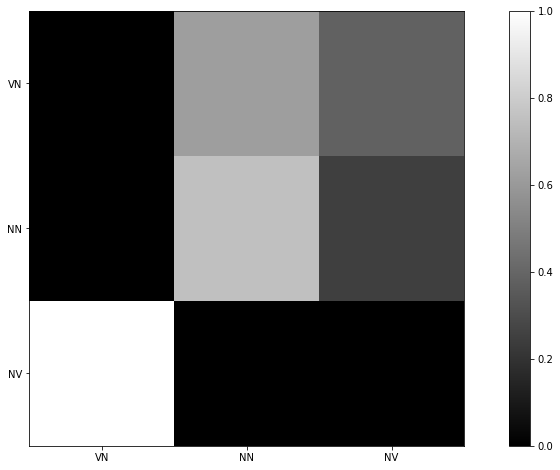

In [29]:
plt.imshow(a, vmin=0, vmax=1, cmap='gray')
plt.xticks([nn, nv, vn], labels=['NN', 'NV', 'VN'])
plt.yticks([nn, nv, vn], labels=['NN', 'NV', 'VN'])
plt.colorbar()
a

As expected, the transition matrix contains zeros at the illegal transitions (NN to VN, VN to VN, NV to NN, and NV to NV).

In [30]:
mus = [
    data_pca[kmeans.labels_ == 0, :20].mean(axis=0),
    data_pca[kmeans.labels_ == 1, :20].mean(axis=0),
    data_pca[kmeans.labels_ == 2, :20].mean(axis=0)
]
covs = [
    np.cov(data_pca[kmeans.labels_ == 0, :20].transpose()),
    np.cov(data_pca[kmeans.labels_ == 1, :20].transpose()),
    np.cov(data_pca[kmeans.labels_ == 2, :20].transpose())
]

In [31]:
states_sim = [np.random.choice([0, 1, 2], p=stat)]
for _ in range(1, 200):
    states_sim.append(np.random.choice([0, 1, 2], p=a[states_sim[-1]]))
states_sim = np.array(states_sim)
data_sim = np.array([
    scipy.stats.multivariate_normal(mus[s], covs[s], allow_singular=False).rvs() for s in states_sim
])

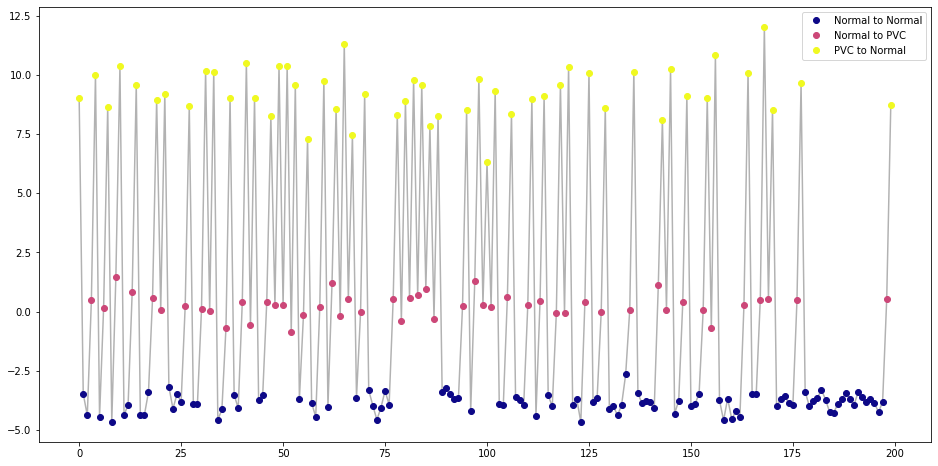

In [32]:
component = 0

plt.plot(data_sim[:,component], color='black', alpha=0.3)
plt.plot(np.where(states_sim == nn)[0], 
         data_sim[:,component][states_sim == nn], 'o', 
         color=cmap(0), label='Normal to Normal')
plt.plot(np.where(states_sim == nv)[0], 
         data_sim[:,component][states_sim == nv], 'o', 
         color=cmap(1), label='Normal to PVC')
plt.plot(np.where(states_sim == vn)[0], 
         data_sim[:,component][states_sim == vn], 'o', 
         color=cmap(2), label='PVC to Normal')

plt.legend()
pass

When we sample from the model, the series actually does not look so different from the original data above. Maybe it is a simple Markov chain after all...

Lets try a third order Markov chain anyway:

In [33]:
transitions = zip(kmeans.labels_[:-3], kmeans.labels_[1:-2], kmeans.labels_[2:-1], kmeans.labels_[3:])
transition_count = Counter(transitions)
a = np.array(
    [[[[transition_count[(i,j,k,l)]
        for l in range(3)]
       for k in range(3)] 
      for j in range(3)] 
     for i in range(3)]
)
a = a + 1  # to avoid division by zero in cases that are never reached
a = a / a.sum(axis=3)[:,:,:,np.newaxis]

In [34]:
states_sim = list(kmeans.labels_[:3])  # start the simulation with the first 3 beats of the data
for _ in range(1, 200):
    states_sim.append(np.random.choice([0, 1, 2], p=a[states_sim[-3],states_sim[-2],states_sim[-1]]))
states_sim = np.array(states_sim)
data_sim = np.array([
    scipy.stats.multivariate_normal(mus[s], covs[s], allow_singular=False).rvs() for s in states_sim
])

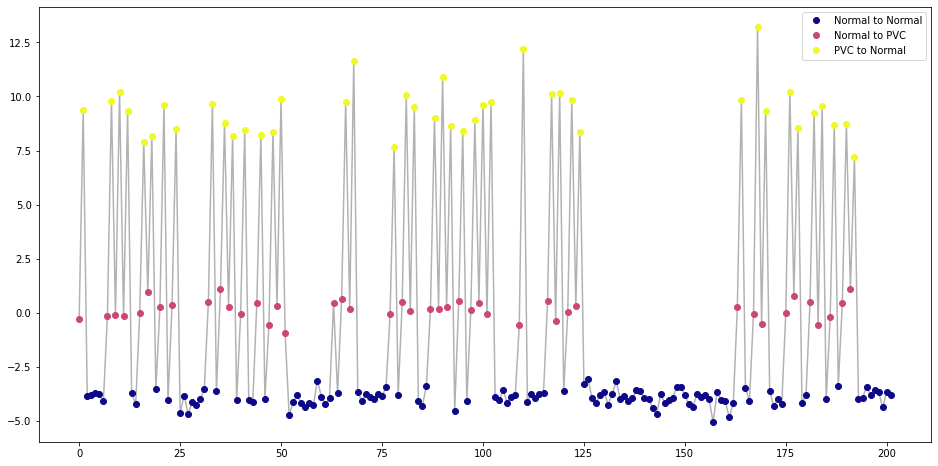

In [35]:
component = 0

plt.plot(data_sim[:,component], color='black', alpha=0.3)
plt.plot(np.where(states_sim == nn)[0], 
         data_sim[:,component][states_sim == nn], 'o', 
         color=cmap(0), label='Normal to Normal')
plt.plot(np.where(states_sim == nv)[0], 
         data_sim[:,component][states_sim == nv], 'o', 
         color=cmap(1), label='Normal to PVC')
plt.plot(np.where(states_sim == vn)[0], 
         data_sim[:,component][states_sim == vn], 'o', 
         color=cmap(2), label='PVC to Normal')

plt.legend()
pass

There are some illegal transition in the simulated data because I had to add 1 to the transition matrix to avoid dividing by zero in cases where a combination of previous states was never seen before. As a result, illegal transitions are merely unlikely, not impossible.

In [36]:
def eval_loop(loop):
    # (geometric) mean probability per transition of one transition cycle through a loop,
    # only works with legal loops
    return reduce(lambda a, b: a*b, [
        a[loop[(t-3) % len(loop)], loop[(t-2) % len(loop)], loop[(t-1) % len(loop)], loop[t % len(loop)]] 
        for t in range(len(loop))
    ])**(1/len(loop))

In [37]:
# All legal loops up to a length of 6
loop = [nn]
print(loop, eval_loop(loop))

loop = [nv, vn]
print(loop, eval_loop(loop))

loop = [nv, vn, nn]
print(loop, eval_loop(loop))

loop = [nv, vn, nn, nn]
print(loop, eval_loop(loop))

loop = [nv, vn, nn, nn, nn]
print(loop, eval_loop(loop))
loop = [nv, vn, nv, vn, nn]
print(loop, eval_loop(loop))

loop = [nv, vn, nn, nn, nn, nn]
print(loop, eval_loop(loop))
loop = [nv, vn, nv, vn, nn, nn]
print(loop, eval_loop(loop))

loop = [nv, vn, nn, nn, nn, nn, nn]
print(loop, eval_loop(loop))
loop = [nv, vn, nv, vn, nn, nn, nn]
print(loop, eval_loop(loop))
loop = [nv, vn, nn, nv, vn, nn, nn]
print(loop, eval_loop(loop))

[1] 0.8330849478390462
[2, 0] 0.6476754624015638
[2, 0, 1] 0.6522255452516513
[2, 0, 1, 1] 0.5611049118864447
[2, 0, 1, 1, 1] 0.529795685697833
[2, 0, 2, 0, 1] 0.6122425624930695
[2, 0, 1, 1, 1, 1] 0.5713100919587755
[2, 0, 2, 0, 1, 1] 0.5596717806419639
[2, 0, 1, 1, 1, 1, 1] 0.6029403938925811
[2, 0, 2, 0, 1, 1, 1] 0.5373792523739909
[2, 0, 1, 2, 0, 1, 1] 0.5984843710803811


The loops of states with the highest (geometric) mean probability per transition are:
1. Simply repeating normal beats.
2. Alternating one PVC and two normal beats.
3. Alternating one PVC and one normal beats.
4. PVC, Normal, PVC, Normal, Normal.

The loop without PVC is the winner by a lot, the others are relatively close, I was hopping for more interesting results, like loops that switch the rhythm (e.g. PVC, Normal, PVC, Normal, Normal) being very unlikely...

# TODO

- Fit a hidden Markov model
- Make the length of the curves part of the data and model it explicitly.
- Use a functional basis instead of linear resampling.
- Use a normal ECG baseline wander remove technique.
- I have yet to find something with HMMs that is not already clear from the simpler methods (k-means).
- Analyze a different ECG recording.
- Look at completely different data.
- ...